In [127]:
import numpy as np
import scipy.io 
import matplotlib.pyplot as plt
import pandas as pd
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
import networkx as nx

from sklearn.cluster import KMeans

In [136]:
edges_data = pd.read_csv("./data/les-mis-edge.csv")
nodes_data = pd.read_csv("./data/les-mis-node.csv")

In [137]:
node_to_idx = {ele['Id']:idx for idx, ele in nodes_data.iterrows()}
edge_index = [[node_to_idx[ele[name]] for idx, ele in edges_data.iterrows()] for name in ["Source", "Target"]]
edge_index = torch.tensor(edge_index)

text_list = list(nodes_data["Label"])

In [152]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(edge_index, embedding_dim=16, walk_length=10,
                 context_size=5, walks_per_node=10,
                 num_negative_samples=5, p=1, q=2, sparse=True).to(device)

loader = model.loader(batch_size=32, shuffle=True, num_workers=4)

In [153]:
def train(optimizer):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [154]:
loss_hist = []
lr = 0.02
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.02)
for epoch in range(1, 51):
    if epoch % 50 == 0:
        lr /= 2
        optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=lr)
    loss = train(optimizer)
    loss_hist.append(loss)

In [155]:
model.eval()
z = model(torch.arange(len(nodes_data), device=device))
z = TSNE(n_components=2).fit_transform(z.cpu().detach().numpy())

In [156]:
temp = model(torch.arange(len(nodes_data), device=device))
print(temp.shape)

kmeans = KMeans(n_clusters = 6, random_state=0).fit(temp.detach().numpy())
color_labels = kmeans.labels_
color_set = ["bisque", "lime", "darkblue",\
             "violet", "salmon", "slategray"]


torch.Size([181, 16])


In [157]:
G = nx.Graph()
G.add_nodes_from(list(np.arange(nodes_data.shape[0])))
G.add_edges_from([[int(ele[0]), int(ele[1])] for ele in zip(edge_index[0], edge_index[1])])
color_map = []
for node in G:
    color_map.append(color_set[color_labels[node]])

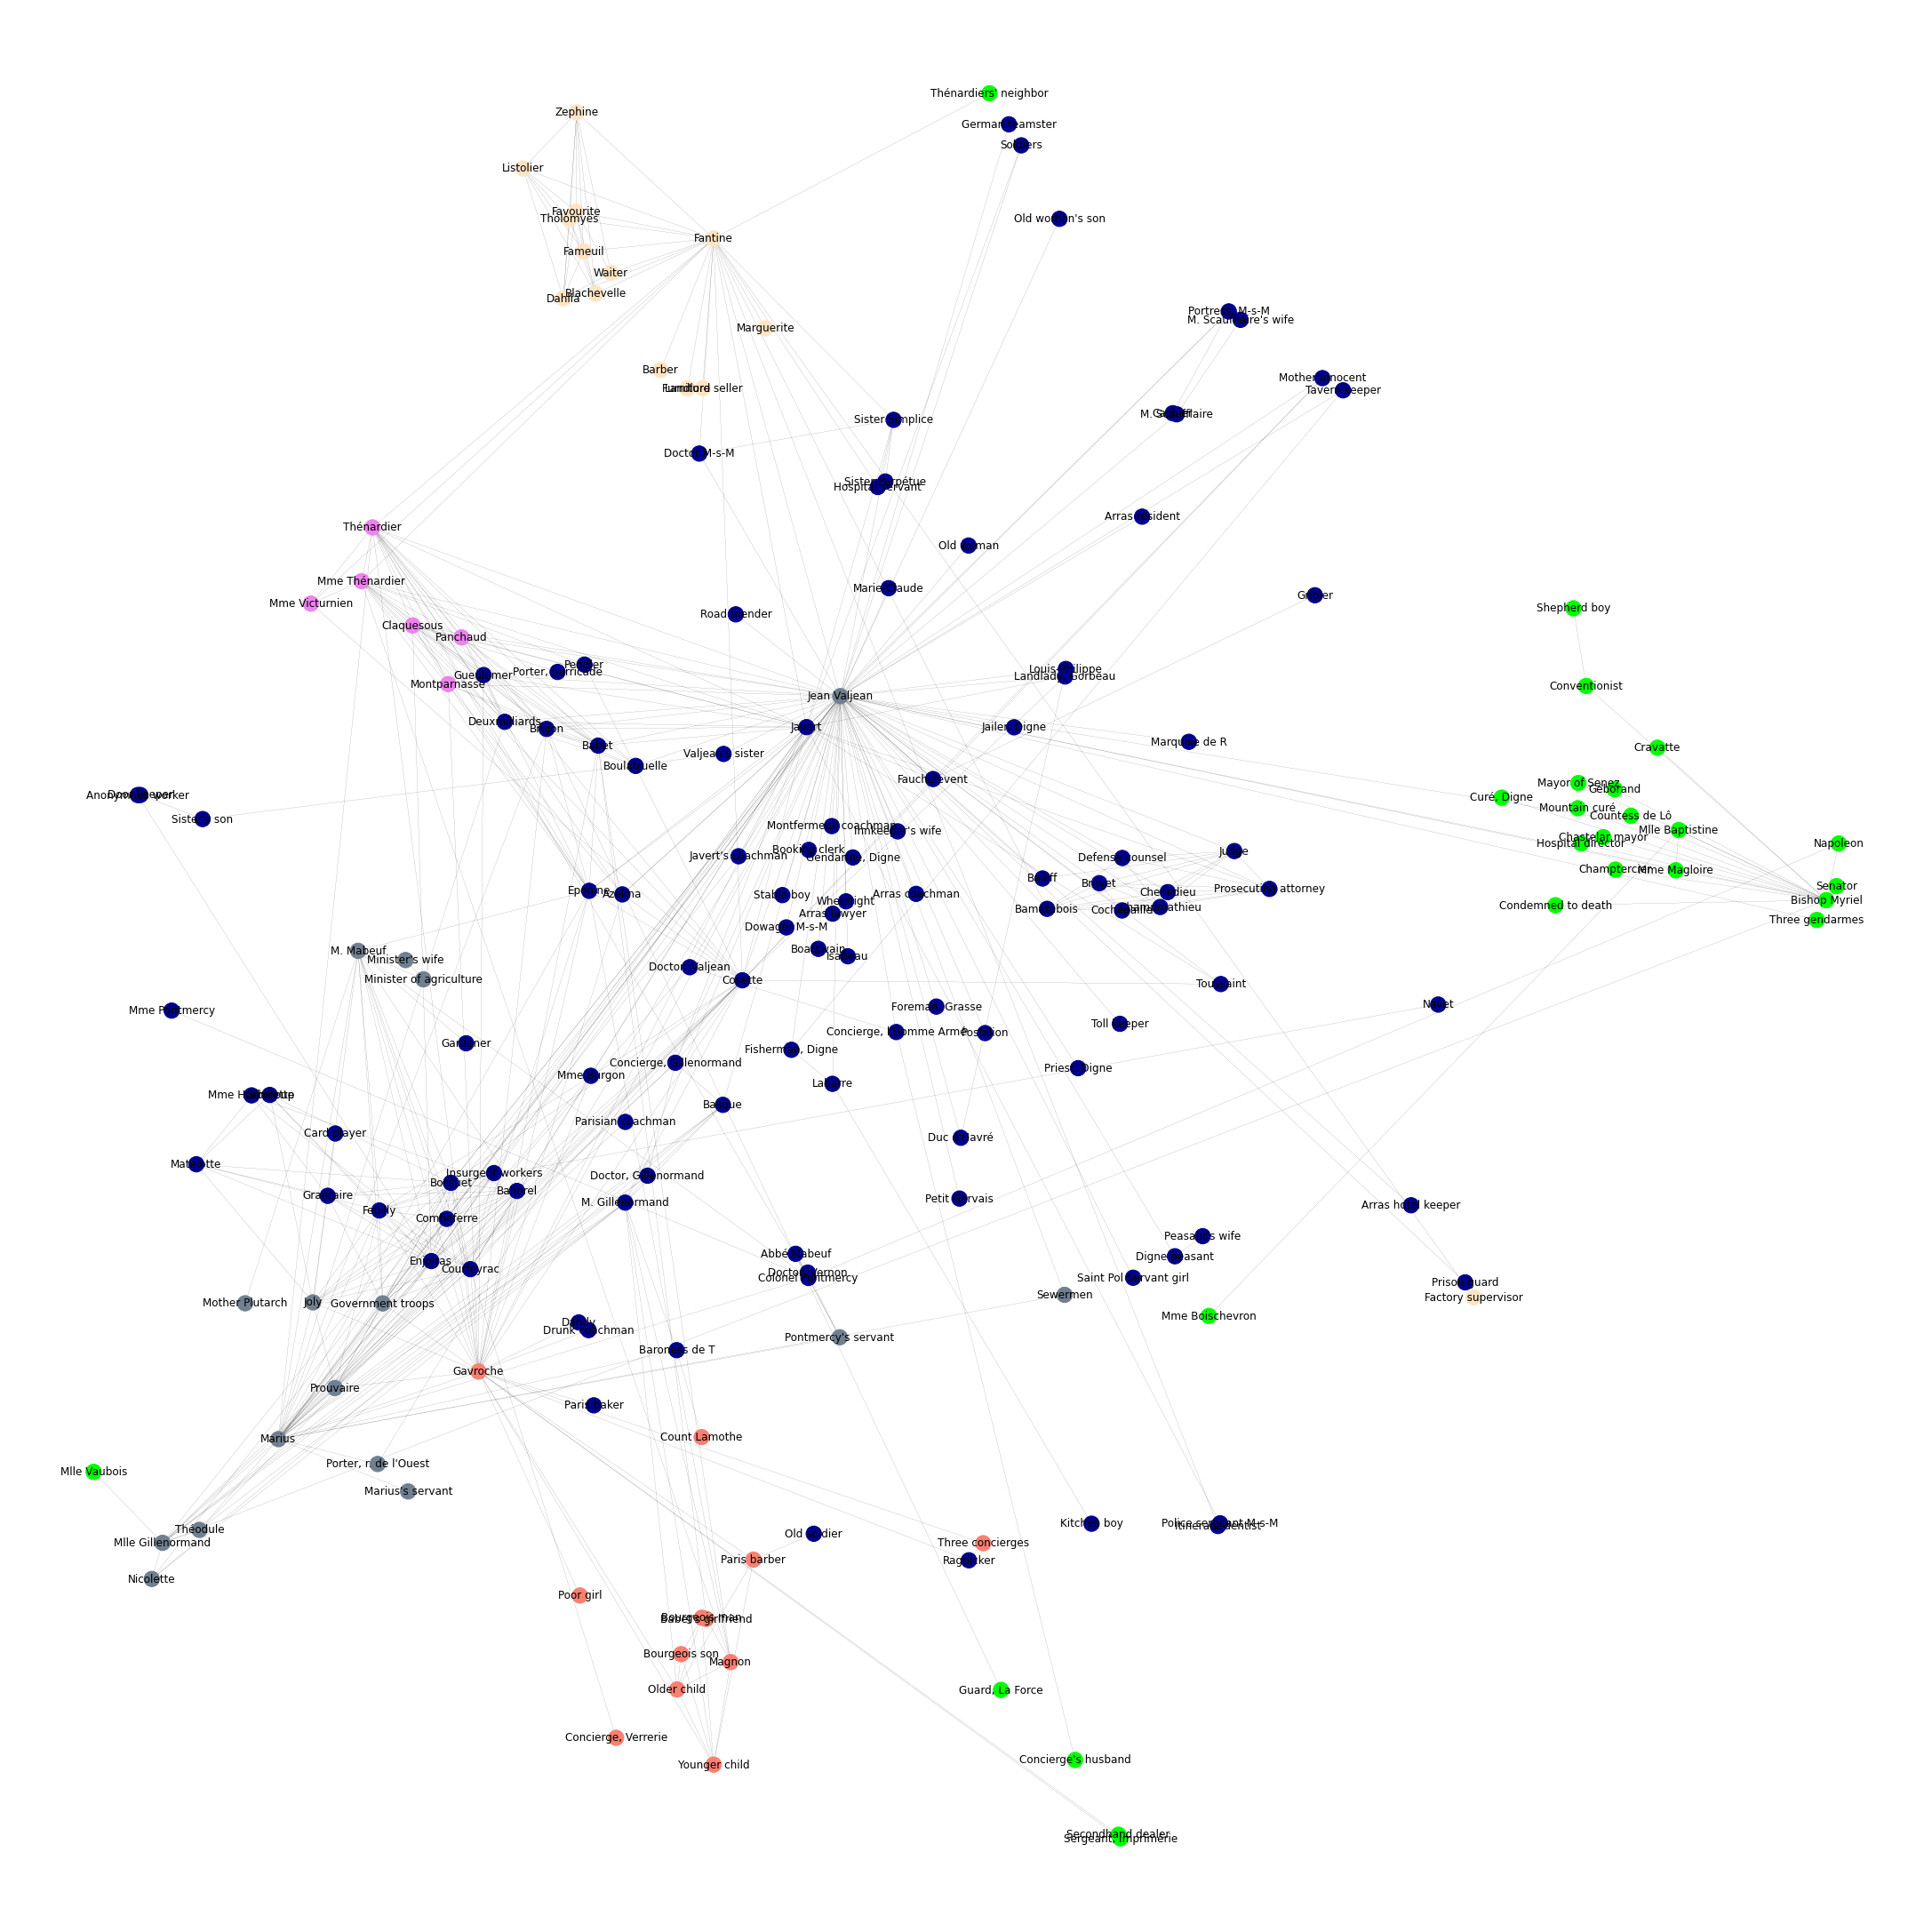

In [158]:
pos = z
plt.figure(figsize=(30, 30))
nx.draw(G, pos = pos, node_color=color_map, width = 0.1)
labels = {idx:val for idx, val in enumerate(text_list)}
_ = nx.draw_networkx_labels(G, pos = pos, labels = labels)